In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [14]:
import sys
sys.path.append('../')

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

from sdebridge.diffusion_bridge import DiffusionBridge
from sdebridge.networks import ScoreNet
from sdebridge.utils import plot_2d_vector_field, plot_2d_trajectories, plot_trajectories, eval_score

plt.style.use('ggplot')

## 2 Dimensional

### Learn the transition density of $X_t$

In [48]:
d = 2

model = DiffusionBridge(
    drift=lambda x, t: 0.0 * jnp.ones(d),
    diffusion=lambda x, t: jnp.array([[1.0, 0.0], [0.0, 1.0]]),     
    dim=d,
    end_time=1.0,
    num_steps=50,
    true_score_transition=lambda x, x0, t: -(x - x0) / t,
    true_score_h=lambda x, xT, t, T: -(x - xT) / (T - t),
)

(32, 51, 2)
(32, 50, 2)


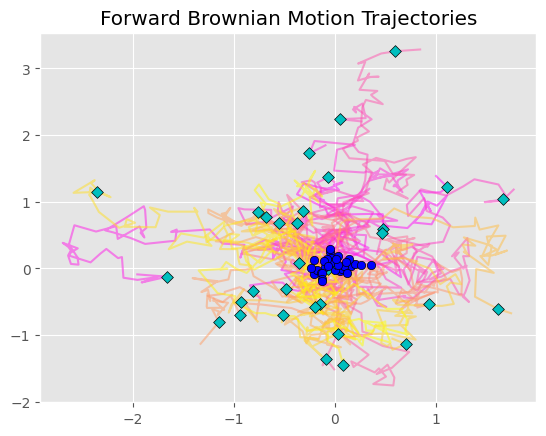

In [28]:
forward_brownian_motion = model.simulate_forward_process(initial_condition=jnp.tile(jnp.array([[0.0, 0.0]]), reps=(32, 1)))
print(forward_brownian_motion["trajectories"].shape)
print(forward_brownian_motion["brownian_increments"].shape)
plot_2d_trajectories(forward_brownian_motion["trajectories"], title="Forward Brownian Motion Trajectories")

In [29]:
train_params = {"batch_size": 32, "num_epochs": 20, "num_batches_per_epoch": 50, "learning_rate": 5e-3}
score_transition_net = ScoreNet(out_dim=model.d,
                                time_embedding_dim=64,
                                embedding_dim=64,
                                act='leaky_relu',
                                encoder_layer_dims=[64, 64],
                                decoder_layer_dims=[64, 64],
                                using_batchnorm=False)
score_transition_state = model.learn_forward_transition_score(score_transition_net, 
                                                              initial_condition=jnp.array([0.0, 0.0]), 
                                                              training_params=train_params)

Epoch 1 / 20: loss = 45.9008
Epoch 2 / 20: loss = 44.8708
Epoch 3 / 20: loss = 44.9779
Epoch 4 / 20: loss = 44.8514
Epoch 5 / 20: loss = 44.8465
Epoch 6 / 20: loss = 44.9420
Epoch 7 / 20: loss = 44.5577
Epoch 8 / 20: loss = 44.9318
Epoch 9 / 20: loss = 44.9864
Epoch 10 / 20: loss = 44.8939
Epoch 11 / 20: loss = 44.4940
Epoch 12 / 20: loss = 44.9227
Epoch 13 / 20: loss = 44.5690
Epoch 14 / 20: loss = 44.8609
Epoch 15 / 20: loss = 44.6794
Epoch 16 / 20: loss = 44.8508
Epoch 17 / 20: loss = 44.8901
Epoch 18 / 20: loss = 44.7749
Epoch 19 / 20: loss = 44.8031
Epoch 20 / 20: loss = 44.6582


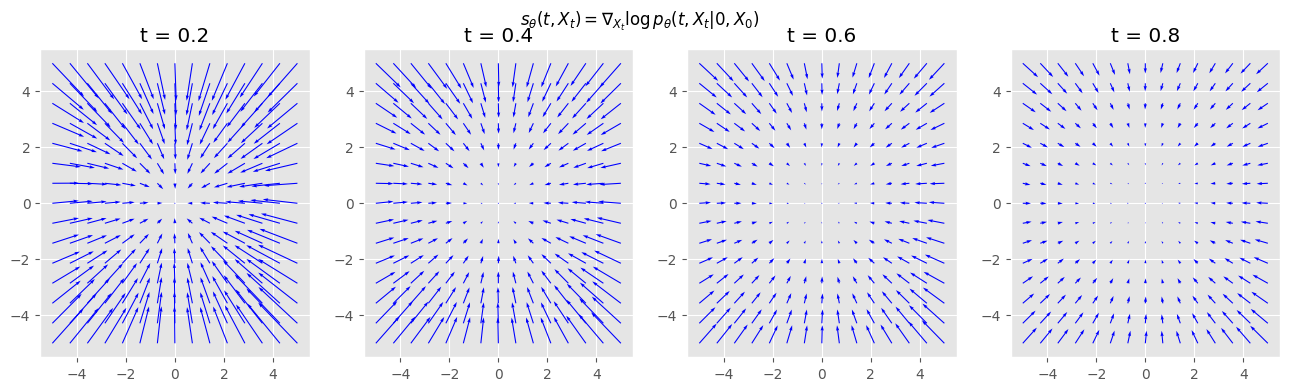

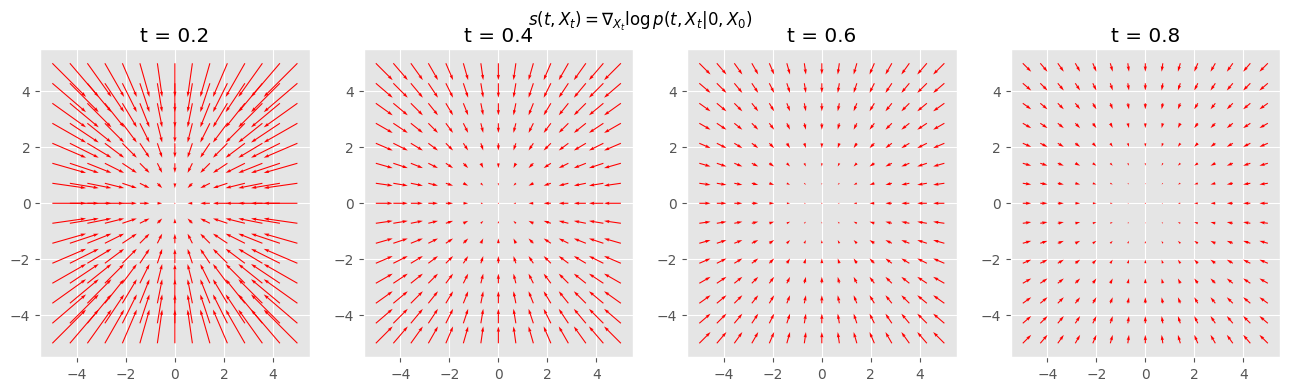

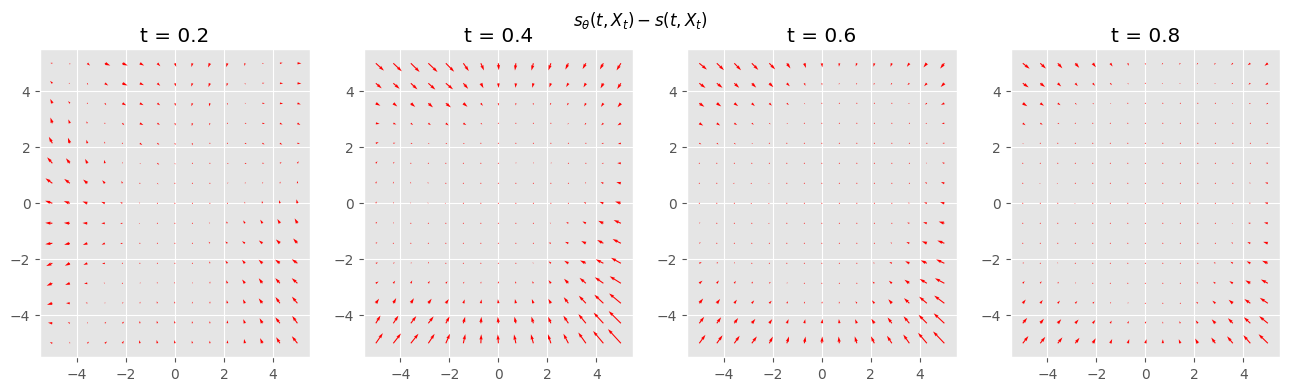

In [30]:
plot_2d_vector_field(X=lambda x, t: eval_score(score_transition_state, x, t),
                     X_ref=None,
                     xs=jnp.linspace(-5.0, 5.0, 15),
                     ts=jnp.linspace(0.2, 0.8, 3+1),
                     suptitle=r"$s_{\theta}(t, X_t)=\nabla_{X_t}\log p_{\theta}(t, X_t|0, X_0)$",
                     scale=200)

plot_2d_vector_field(X=None,
                     X_ref=lambda x, t, x0: -(x-x0)/t,
                     xs=jnp.linspace(-5.0, 5.0, 15),
                     ts=jnp.linspace(0.2, 0.8, 3+1),
                     suptitle=r"$s(t, X_t)=\nabla_{X_t}\log p(t,X_t|0,X_0)$",
                     scale=200,
                     x0=jnp.array([0.0, 0.0]))

plot_2d_vector_field(X=None,
                     X_ref=lambda x, t, x0: eval_score(score_transition_state, x, t) - (-(x-x0)/t),
                     xs=jnp.linspace(-5.0, 5.0, 15),
                     ts=jnp.linspace(0.2, 0.8, 3+1),
                     suptitle=r"$s_{\theta}(t, X_t) - s(t, X_t)$",
                     scale=200,
                     x0=jnp.array([0.0, 0.0]))

### Use learned transition score to simulate the backward bridge

(32, 51, 2)
(32, 50, 2)


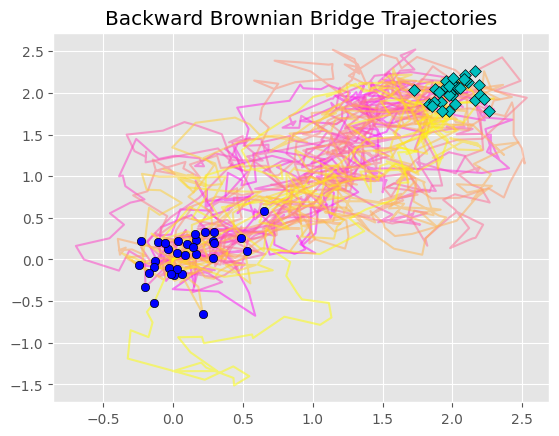

In [31]:
backward_brownian_bridge = model.simulate_backward_bridge(score_transition_state=score_transition_state, 
                                                          initial_condition=jnp.tile(jnp.array([[2.0, 2.0]]), reps=(32, 1)), 
                                                          terminal_condition=jnp.tile(jnp.array([[0.0, 0.0]]), reps=(32, 1)), 
                                                          using_true_score=False)
print(backward_brownian_bridge["trajectories"].shape)
print(backward_brownian_bridge["brownian_increments"].shape)
plot_2d_trajectories(backward_brownian_bridge["trajectories"], title="Backward Brownian Bridge Trajectories")

### Exam the intermediate stage distribution

For a Brownian bridge $(X^*_t)$, $p^*(t, X^*_t)$ is the transition density, which can be written as:
$$ p^*(t, x_t) = \frac{p(t, x_t|0, x_0)p(T, x_T|t, x_t)}{p(T, x_T|0, x_0)} $$
Take the score for the both sides w.r.t $x_t$:
$$ \nabla_{x_t}\log p^*(t, x_t) = \nabla_{x_t}\log p(t, x_t|0, x_0) + \nabla_{x_t} \log p(T, x_T|t, x_t) - \nabla_{x_t} \log p(T, x_T|0, x_0) $$
Considering all the $p$s have Gaussian closed forms:
$$ p(t, x_t|0, x_0) = C_1\exp(-\frac{\|x_t-x_0\|^2}{2t}) $$
$$ p(T, x_T|t, x_t) = C_2\exp(-\frac{\|x_T-x_t\|^2}{2(T-t)}) $$
$$ p(T, x_T|0, x_0) = C_3\exp(-\frac{\|x_T-x_0\|^2}{2T}) $$
The score of the transition density of the Brownian bridge is:
$$ s^*(t, x_t) = \nabla_{x_t} \log p^*(t, x_t) = \frac{x_T-x_t}{T-t} - \frac{x_t-x_0}{t} $$

In [32]:
# Covariance calculations
def product_gaussian(sigma1, sigma2):
    """ Covariance of N(mu1, sigma1^2) * N(mu2, sigma2^2)
    """
    sigma = (sigma1**2 * sigma2**2) / (sigma1**2 + sigma2**2)
    return sigma

def quotient_gaussian(sigma1, sigma2):
    """ Covariance of N(mu1, sigma1^2) / N(mu2, sigma2^2)
    """
    sigma = (sigma1**2 * sigma2**2) / (sigma1**2 - sigma2**2)
    return sigma

def forward_browian_bridge_transition(t, T):
    sigma1 = t
    sigma2 = T - t
    sigma3 = T
    sigma0 = product_gaussian(sigma1, sigma2)
    sigma = quotient_gaussian(sigma0, sigma3)
    return sigma

In [33]:
num_trajectories = 4096
XT = jnp.tile(jnp.array([[2.0, 2.0]]), reps=(num_trajectories, 1))
X0 = jnp.tile(jnp.array([[0.0, 0.0]]), reps=(num_trajectories, 1))
backward_brownian_bridge = model.simulate_backward_bridge(score_transition_state=score_transition_state, 
                                                          initial_condition=XT, 
                                                          terminal_condition=X0, 
                                                          using_true_score=True)
print(backward_brownian_bridge["trajectories"].shape)
print(backward_brownian_bridge["brownian_increments"].shape)

(4096, 51, 2)
(4096, 50, 2)


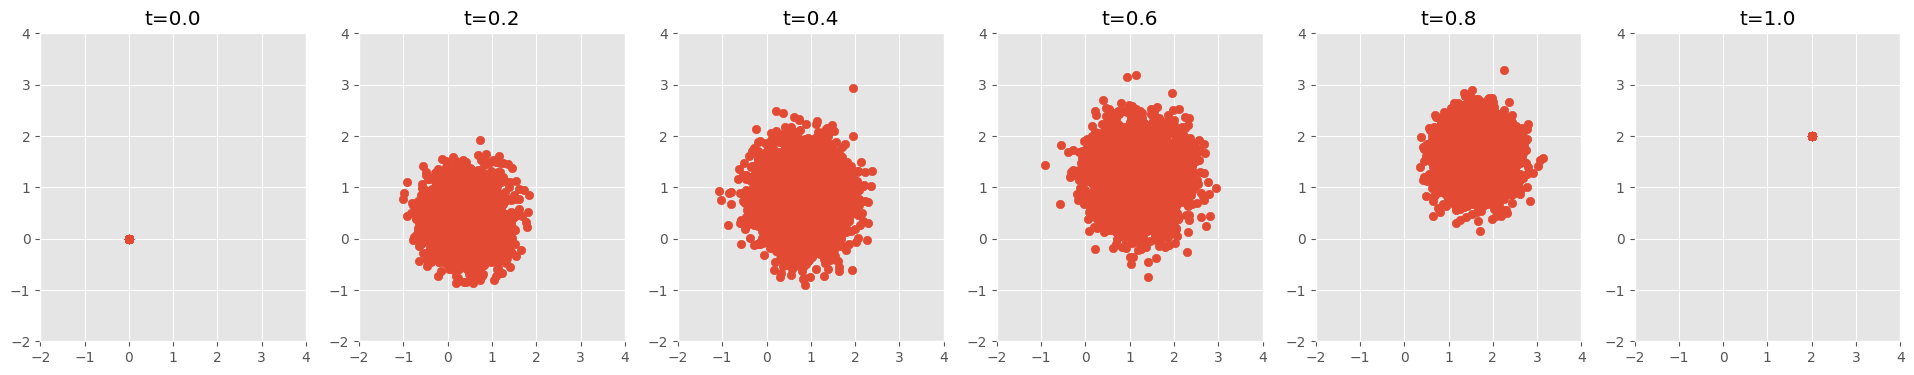

In [34]:
fig, ax = plt.subplots(1, 6, figsize=(24, 4))
for i in range(5+1):
    ax[i].scatter(backward_brownian_bridge["trajectories"][:, i*10, 0], backward_brownian_bridge["trajectories"][:, i*10, 1])
    ax[i].set_title(f"t={model.ts[i*10]:.1f}")
    ax[i].set_xlim([-2.0, 4.0])
    ax[i].set_ylim([-2.0, 4.0])

Text(0, 0.5, 'MSE')

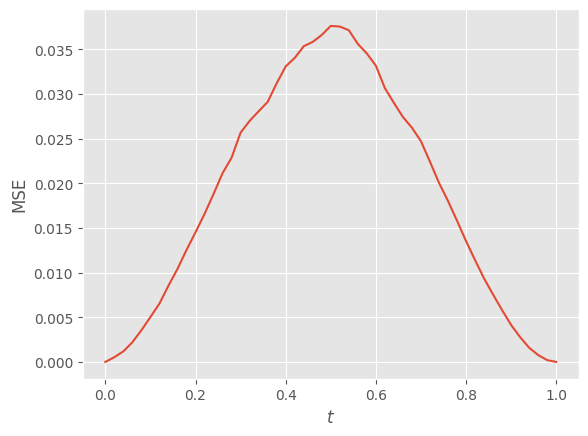

In [35]:
true_variances = jax.vmap(forward_browian_bridge_transition, in_axes=(0, None))(model.ts, model.T)
backward_brownian_bridge_covariance = jax.vmap(lambda x: jnp.cov(x, rowvar=False), in_axes=1)(backward_brownian_bridge["trajectories"])
errors = jax.vmap(lambda x, var: jnp.mean(jnp.square(x - jnp.eye(2)*var)), in_axes=(0, 0))(backward_brownian_bridge_covariance, true_variances)
plt.plot(model.ts, errors)
plt.xlabel(r"$t$")
plt.ylabel("MSE")

### Learn the transition density of the forward bridge from the simulated backward bridge

In [49]:
train_params = {"batch_size": 32, "num_epochs": 20, "num_batches_per_epoch": 50, "learning_rate": 5e-3}
score_marginal_net = ScoreNet(out_dim=model.d,
                              time_embedding_dim=64,
                              embedding_dim=64,
                              act='leaky_relu',
                              encoder_layer_dims=[64, 64],
                              decoder_layer_dims=[64, 64],
                              using_batchnorm=False)
score_marginal_state = model.learn_marginal_score(score_marginal_net=score_marginal_net,
                                                   initial_condition=jnp.array([2.0, 2.0]),
                                                   terminal_condition=jnp.array([0.0, 0.0]),
                                                   score_transition_state=None,
                                                   training_params=train_params)

Epoch 1 / 20: loss = 48.8235
Epoch 2 / 20: loss = 48.9124
Epoch 3 / 20: loss = 49.1582
Epoch 4 / 20: loss = 48.9891
Epoch 5 / 20: loss = 49.0992
Epoch 6 / 20: loss = 49.2957
Epoch 7 / 20: loss = 48.7806
Epoch 8 / 20: loss = 49.2260
Epoch 9 / 20: loss = 49.4200
Epoch 10 / 20: loss = 49.2201
Epoch 11 / 20: loss = 48.8110
Epoch 12 / 20: loss = 49.2595
Epoch 13 / 20: loss = 49.0030
Epoch 14 / 20: loss = 49.1397
Epoch 15 / 20: loss = 49.1184
Epoch 16 / 20: loss = 49.1765
Epoch 17 / 20: loss = 49.2304
Epoch 18 / 20: loss = 49.0006
Epoch 19 / 20: loss = 49.1681
Epoch 20 / 20: loss = 49.1081


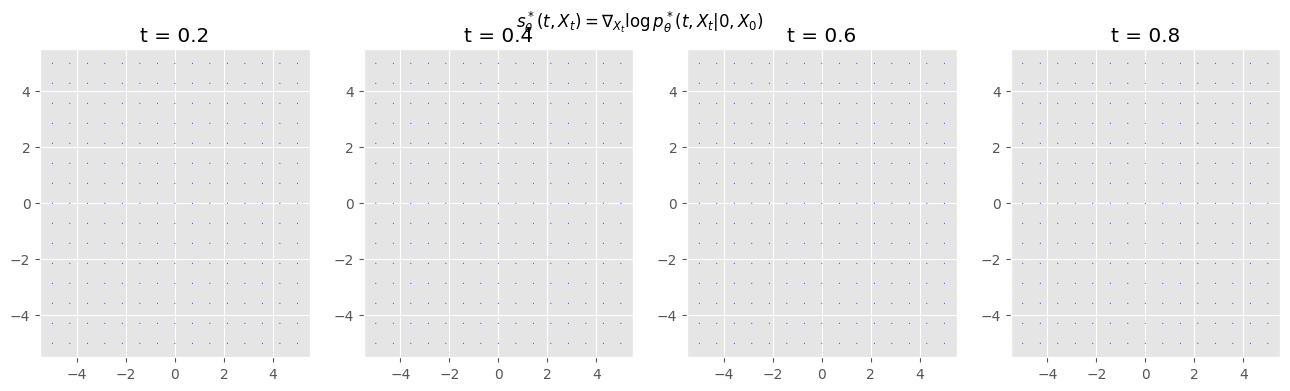

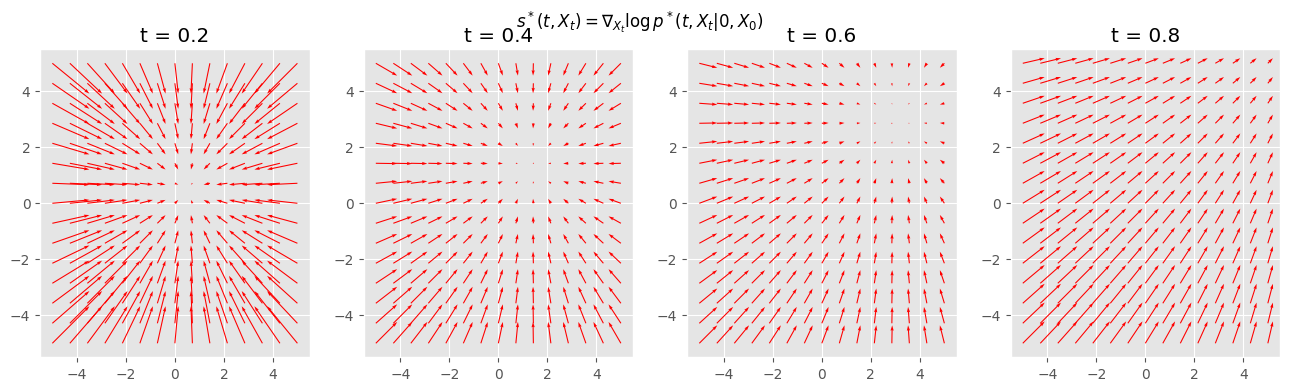

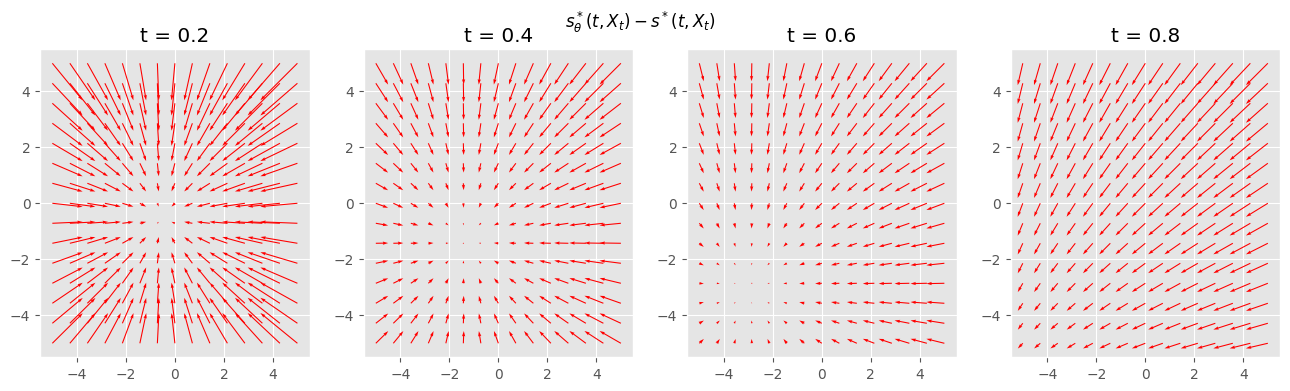

In [50]:
plot_2d_vector_field(X=lambda x, t: eval_score(score_marginal_state, x, t),
                     X_ref=None,
                     xs=jnp.linspace(-5.0, 5.0, 15),
                     ts=jnp.linspace(0.2, 0.8, 3+1),
                     suptitle=r"$s^*_{\theta}(t, X_t)=\nabla_{X_t}\log p^*_{\theta}(t, X_t|0, X_0)$",
                     scale=200)

plot_2d_vector_field(X=None,
                     X_ref=lambda x, t, x0, xT, T: (xT-x0) / (T-t) - (x-x0) / t,
                     xs=jnp.linspace(-5.0, 5.0, 15),
                     ts=jnp.linspace(0.2, 0.8, 3+1),
                     suptitle=r"$s^*(t, X_t)=\nabla_{X_t}\log p^*(t,X_t|0,X_0)$",
                     scale=200,
                     x0=jnp.array([0.0, 0.0]),
                     xT=jnp.array([2.0, 2.0]),
                     T=1.0)

plot_2d_vector_field(X=None,
                     X_ref=lambda x, t, x0, xT, T: eval_score(score_marginal_state, x, t) - (xT-x0) / (T-t) - (x-x0) / t,
                     xs=jnp.linspace(-5.0, 5.0, 15),
                     ts=jnp.linspace(0.2, 0.8, 3+1),
                     suptitle=r"$s^*_{\theta}(t, X_t) - s^*(t, X_t)$",
                     scale=200,
                     x0=jnp.array([0.0, 0.0]),
                     xT=jnp.array([2.0, 2.0]),
                     T=1.0)

(32, 51, 2)


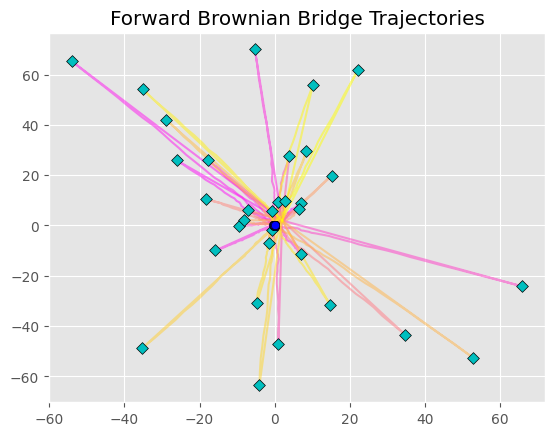

In [41]:
forward_brownian_bridge = model.simulate_forward_bridge(score_transition_state=score_transition_state, 
                                                                     score_marginal_state=score_marginal_state,
                                                                     initial_condition=jnp.tile(jnp.array([[0.0, 0.0]]), reps=(32, 1)), 
                                                                     terminal_condition=jnp.tile(jnp.array([[2.0, 2.0]]), reps=(32, 1)), 
                                                                     using_true_score=False)
print(forward_brownian_bridge["trajectories"].shape)
plot_2d_trajectories(forward_brownian_bridge["trajectories"], title="Forward Brownian Bridge Trajectories")

### Higher dimension

In [51]:
d = 16

model = DiffusionBridge(
    drift=lambda x, t: 0.0 * jnp.ones(d),
    diffusion=lambda x, t: jnp.eye(d),
    dim=d,
    end_time=1.0,
    num_steps=100,
    true_score_transition=None,
    true_score_h=None,
)

In [52]:
def sample_circle(num_points: int) -> jnp.ndarray:
    theta = jnp.linspace(0, 2 * jnp.pi, num_points, endpoint=False)
    x = jnp.cos(theta)
    y = jnp.sin(theta)
    return jnp.stack([x, y], axis=1).flatten()

def sample_square(num_points: int) -> jnp.ndarray:
    shift = 2.0 * jnp.ones(2*num_points)
    num_points_per_side = num_points // 4
    x1 = jnp.linspace(-1, 1, num_points_per_side, endpoint=False)
    x2 = jnp.linspace(1, -1, num_points_per_side, endpoint=False)
    y1 = jnp.linspace(-1, 1, num_points_per_side, endpoint=False)
    y2 = jnp.linspace(1, -1, num_points_per_side, endpoint=False)
    xy1 = jnp.stack([x1, jnp.ones_like(x1)], axis=1)
    xy2 = jnp.stack([jnp.ones_like(y1), y2], axis=1)
    xy3 = jnp.stack([x2, -jnp.ones_like(x2)], axis=1)
    xy4 = jnp.stack([-jnp.ones_like(y1), y1], axis=1)
    return jnp.concatenate([xy1, xy2, xy3, xy4], axis=0).flatten() + shift

(16,) (16,)


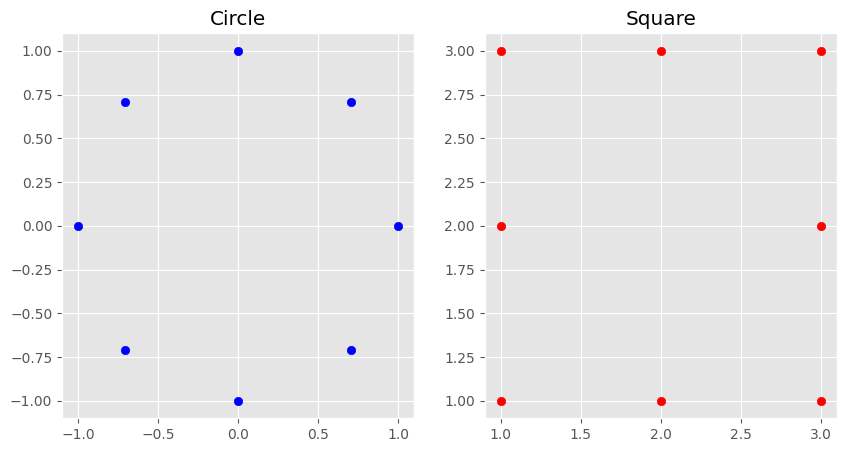

In [53]:
circles = sample_circle(num_points=d//2)
squares = sample_square(num_points=d//2)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].scatter(circles.reshape(-1, 2)[:, 0], circles.reshape(-1, 2)[:, 1], color='b')
ax[0].set_title("Circle")
ax[1].scatter(squares.reshape(-1, 2)[:, 0], squares.reshape(-1, 2)[:, 1], color='r')
ax[1].set_title("Square")
print(circles.shape, squares.shape)

(5, 101, 16)


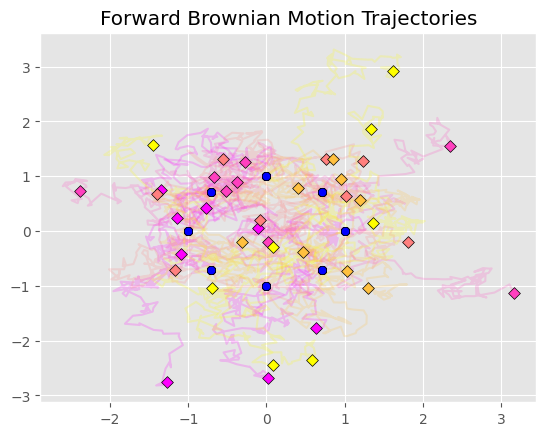

In [55]:
initial_condition = sample_circle(num_points=d//2)
forward_brownian_motion = model.simulate_forward_process(initial_condition=jnp.tile(initial_condition, reps=(5, 1)))
print(forward_brownian_motion["trajectories"].shape)
plot_trajectories(forward_brownian_motion["trajectories"], title="Forward Brownian Motion Trajectories")

In [56]:
train_params = {"batch_size": 64, "num_epochs": 50, "num_batches_per_epoch": 50, "learning_rate": 5e-3}
score_transition_net = ScoreNet(out_dim=model.d,
                                time_embedding_dim=128,
                                embedding_dim=128,
                                act='leaky_relu',
                                encoder_layer_dims=[128, 128],
                                decoder_layer_dims=[128, 128],
                                using_batchnorm=False)
score_transition_state = model.learn_forward_transition_score(score_transition_net, 
                                                              initial_condition=initial_condition, 
                                                              training_params=train_params)

Epoch 1 / 50: loss = 96.6523
Epoch 2 / 50: loss = 95.0451
Epoch 3 / 50: loss = 94.6623
Epoch 4 / 50: loss = 94.4843
Epoch 5 / 50: loss = 94.3055
Epoch 6 / 50: loss = 94.2567
Epoch 7 / 50: loss = 94.3676
Epoch 8 / 50: loss = 94.3609
Epoch 9 / 50: loss = 94.3212
Epoch 10 / 50: loss = 94.2074
Epoch 11 / 50: loss = 94.2264
Epoch 12 / 50: loss = 94.2435
Epoch 13 / 50: loss = 94.2202
Epoch 14 / 50: loss = 94.1935
Epoch 15 / 50: loss = 94.1559
Epoch 16 / 50: loss = 94.2724
Epoch 17 / 50: loss = 94.2284
Epoch 18 / 50: loss = 94.1113
Epoch 19 / 50: loss = 94.1215
Epoch 20 / 50: loss = 94.2383
Epoch 21 / 50: loss = 94.1720
Epoch 22 / 50: loss = 94.2047
Epoch 23 / 50: loss = 94.1817
Epoch 24 / 50: loss = 94.2127
Epoch 25 / 50: loss = 94.2219
Epoch 26 / 50: loss = 94.1429
Epoch 27 / 50: loss = 94.1711
Epoch 28 / 50: loss = 94.2343
Epoch 29 / 50: loss = 94.1636
Epoch 30 / 50: loss = 94.1853
Epoch 31 / 50: loss = 94.1843
Epoch 32 / 50: loss = 94.0795
Epoch 33 / 50: loss = 94.2197
Epoch 34 / 50: loss

(1, 101, 16)


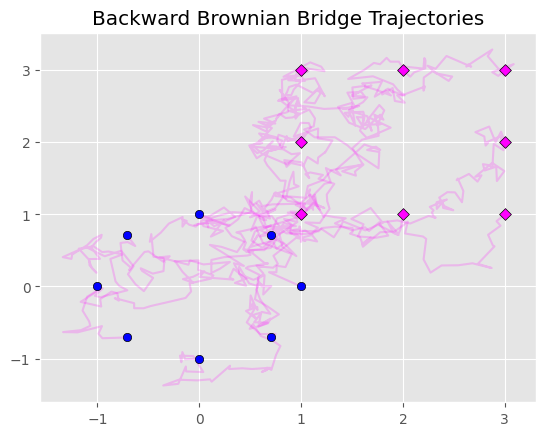

In [60]:
initial_shape = sample_circle(num_points=d//2)
terminal_shape = sample_square(num_points=d//2)

backward_brownian_bridge = model.simulate_backward_bridge(score_transition_state=score_transition_state, 
                                                                       initial_condition=jnp.tile(terminal_shape, reps=(1, 1)), 
                                                                       terminal_condition=jnp.tile(initial_shape, reps=(1, 1)), 
                                                                       using_true_score=False)
print(backward_brownian_bridge["trajectories"].shape)
plot_trajectories(backward_brownian_bridge["trajectories"], title="Backward Brownian Bridge Trajectories")